In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
from datetime import datetime

from pathlib import Path

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

from params import PROJECT_PATH

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING
NET_PARAMS = params.learning.NET_PARAMS

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),

    # Randomly adds a black patch to the image
    Cutout(0.5),
    
    # Randomly cast a shadow on the image
    Shadowcasting(0.5),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_train.csv",
    images_directory=params.learning.DATASET / "images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_train.csv",
    images_directory=params.learning.DATASET / "images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_test.csv",
    images_directory=params.learning.DATASET / "images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (198 samples)
15.0 % of the data for validation (43 samples)
15.0 % of the data for testing (43 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model

model = ResNet18Velocity_Regression_Alt(nb_input_channels=NET_PARAMS["nb_input_channels"],
                                    nb_input_features=NET_PARAMS["nb_input_features"],
                                    nb_classes=1).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity_Regression_Alt(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [11]:
# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer, total_iters=LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the loss and accuracy values
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_regression_loss = train(model,
                                  device,
                                  train_loader,
                                  optimizer,
                                  scheduler,
                                  criterion_regression,
                                  epoch)
    
    # Validation
    val_regression_loss = validate(model,
                                   device,
                                   val_loader,
                                   criterion_regression,
                                   epoch) 
    
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)

    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  5.4210566111973355
Validation regression loss:  5.060315370559692


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  5.105952194758824
Validation regression loss:  4.39331841468811


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  3.5182273728506908
Validation regression loss:  2.7476307153701782


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  2.5890694005148753
Validation regression loss:  1.735469251871109


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.9947793654033117
Validation regression loss:  1.394451379776001


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.682228411946978
Validation regression loss:  0.8758670091629028


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.1475202356066023
Validation regression loss:  0.8892360329627991


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.1005342176982336
Validation regression loss:  0.66203972697258


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.0435654520988464
Validation regression loss:  0.7467965185642242


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9512949500765119
Validation regression loss:  0.6568854749202728


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.0800065738814217
Validation regression loss:  0.7069426774978638


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8668157373155866
Validation regression loss:  0.6440993845462799


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9612859828131539
Validation regression loss:  0.5653876960277557


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8626726354871478
Validation regression loss:  0.6066959202289581


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9376882570130485
Validation regression loss:  0.6215351223945618


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9501705510275704
Validation regression loss:  0.7111437916755676


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.0280412350382124
Validation regression loss:  0.6752103269100189


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.88750992502485
Validation regression loss:  0.6184393465518951


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8402357058865684
Validation regression loss:  0.5708761811256409


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8475760732378278
Validation regression loss:  0.7028511166572571


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9944679822240557
Validation regression loss:  0.5969442427158356


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.0097080894878931
Validation regression loss:  0.5876096785068512


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9103145854813712
Validation regression loss:  0.580139085650444


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8190005379063743
Validation regression loss:  0.5324322581291199


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8078572068895612
Validation regression loss:  0.5506092756986618


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9647109082766941
Validation regression loss:  0.678883820772171


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.9990491909640176
Validation regression loss:  0.680691659450531


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8804301278931754
Validation regression loss:  0.6172915101051331


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8604641216141837
Validation regression loss:  0.5265711843967438


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7951893891607013
Validation regression loss:  0.7182453572750092


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7391274656568255
Validation regression loss:  0.661634624004364


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7627507618495396
Validation regression loss:  0.6504418551921844


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8764347859791347
Validation regression loss:  0.7000988125801086


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8829874992370605
Validation regression loss:  0.5246048718690872


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7705484969275338
Validation regression loss:  0.48272476345300674


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.775493860244751
Validation regression loss:  0.5199529677629471


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7686354773385184
Validation regression loss:  0.5120384097099304


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.862666768687112
Validation regression loss:  0.7243419885635376


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.804989048412868
Validation regression loss:  0.6583491563796997


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8906611800193787
Validation regression loss:  0.726082980632782


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8563239659581866
Validation regression loss:  0.7331121861934662


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8430430633681161
Validation regression loss:  0.6544637382030487


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.798457179750715
Validation regression loss:  0.694652795791626


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8690897652081081
Validation regression loss:  0.5827386677265167


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7258378863334656
Validation regression loss:  0.6924447417259216


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.855602639062064
Validation regression loss:  0.5238071382045746


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.844005925314767
Validation regression loss:  0.594038724899292


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8227473071643284
Validation regression loss:  0.6636204123497009


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8845982466425214
Validation regression loss:  0.6694881916046143


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7127611466816494
Validation regression loss:  0.6141506731510162


## Testing

#### Testing the model

In [12]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
test_regression_loss,\
test_regression_losses = test(model,
                              device,
                              test_loader,
                              criterion_regression,
                              uncertainty_function)

print("Regression loss: ", test_regression_loss)

Regression loss:  0.6191043257713318


#### Generate a log directory

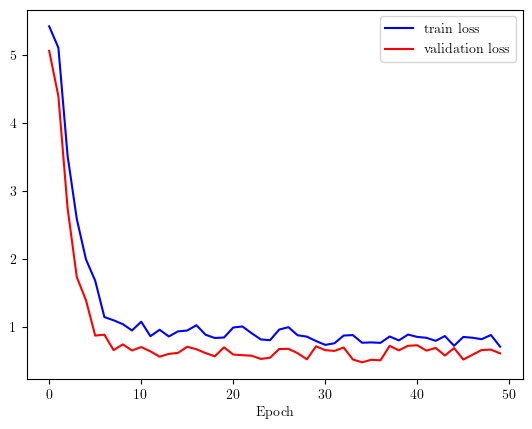

In [13]:
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = Path(
        "logs/_" + params.learning.LOG_DIR
    )
else:
    results_directory = Path(
        "logs/_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    )

generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values)

#### Comparing to the worst possible loss

In [14]:
dataset_dir = PROJECT_PATH /  "datasets/dataset_multimodal_siamese_png_quantilebinning/traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)
costs = costs_df['traversal_cost'].to_numpy()
mean_dataset_value = costs_df['traversal_cost'].mean()

print(mean_dataset_value)

mean_loss = 0.

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images,\
    traversal_costs,\
    linear_velocities in train_loader_pbar:
    mean_tensor_value = torch.tensor(np.full(list(traversal_costs.shape), mean_dataset_value), dtype=torch.float32)

    #loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    #train_loss += loss.item()
    #
    ## Get the number of correct predictions
    #train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()
    
    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value,
        traversal_costs).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)
    
print(mean_loss)



KeyError: 'traversal_cost'

#### Getting some stats about the dataset

## Assessing the relevance of the uncertainty

In [ ]:
##import uncertainty.functions
##import uncertainty.evaluation
##
### Compute the test losses after successive removal of the samples
### with the highest loss and uncertainty
##test_losses_loss, test_losses_uncertainty =\
##    uncertainty.evaluation.uncertainty_relevance(
##        model,
##        device,
##        criterion_regression,
##        uncertainty_function,
##        test,
##        test_set,
##        test_regression_loss,
##        test_regression_losses)

#### Plotting the results

In [ ]:
##plt.plot(range(0, 100, 10),
##         test_losses_loss,
##         "bo--",
##         label="removing samples with highest regression loss",
##         markersize=4)
##plt.plot(range(0, 100, 10),
##         test_losses_uncertainty,
##         "ro--",
##         label="removing samples with highest uncertainty",
##         markersize=4)
##
##plt.legend(loc="upper right")
##plt.xlabel("Percentage of samples removed")
##plt.ylabel("Regression error (MSE)")

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

#### Plotting the results

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")